In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
from itertools import combinations, product

In [49]:
# How many particles we simulate
NUM_PARTICLES = 1000
# Max particle starting speed in m/s
SPEED = 25
# Radius of a particle 
RADIUS = 0.01

In [50]:
# ID for each particle
ids = np.arange(NUM_PARTICLES)

# INITIALISE IN A GRID to avoid overlaps when we start (they create problems with collisions)
GRID_SIZE = int(np.ceil(np.sqrt(NUM_PARTICLES)))

x = list(np.linspace(RADIUS + 0.5/GRID_SIZE ,1 - RADIUS - 0.5/GRID_SIZE,num=GRID_SIZE))

pos = np.array(list(product(x,x))[:NUM_PARTICLES])
pos = np.flipud(np.rot90(pos))


# Initialise random starting velocities, between -SPEED and SPEED
vs = (np.random.random((2, NUM_PARTICLES)) - 0.5) * SPEED * 2

# Particles on the right will be coloured red, on the left will be blue
red = pos[0] > 0.5
blue = pos[0] <= 0.5

# PAIRS OF PARTICLES WE CAN CHECK FOR
pairs = np.asarray(list(combinations(ids, 2)))

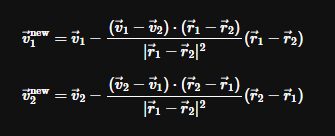

In [51]:
def show(pos, ax):
    cred = matplotlib.collections.PatchCollection(pos[...,red], facecolors = 'red')
    cblue = matplotlib.collections.PatchCollection(pos[...,blue], facecolors = 'blue')
    # ax.scatter(pos[0][red], pos[1][red], color='r', s=8)
    # ax.scatter(pos[0][blue], pos[1][blue], color='b', s=8)
    ax.add_collection(cred)
    ax.add_collection(cblue)
# plt.show()

In [52]:
def step(pos, v, dt=0.0001):
    
    new_pos = pos + v*dt
    # CHECK FOR COLLISIONS and adjust velocities

    # edge collision   
    v[0, new_pos[0] > 1-RADIUS] = -np.abs(v[0, new_pos[0] > 1-RADIUS])
    v[0, new_pos[0] < RADIUS] = np.abs(v[0, new_pos[0] < RADIUS])

    v[1, new_pos[1] > 1 - RADIUS] = -np.abs(v[1, new_pos[1] > 1 - RADIUS])
    v[1, new_pos[1] < RADIUS] = np.abs(v[1, new_pos[1] < RADIUS])
    
    # x, y differences for each pair of particles
    x_diffs = np.diff(new_pos[0,pairs]).T[0]
    check = x_diffs < 2*RADIUS # if two particles are already too far away in the x direction to collide, we don't need to check the y direction
    y_diffs = np.diff(new_pos[1,pairs[check]]).T[0]

    # Pairwise distances of particles which are close enough in the x direction
    dist_pairs = np.sqrt(x_diffs[check]**2 + y_diffs**2)
    # Distance = sqrt(delta_x^2 + delta_y^2)

    # IDs of particles which are touching
    collision = pairs[check][dist_pairs < 2*RADIUS]

    for a, b in collision:

        # USE FORMULA
        v1, v2 = v[:,a], v[:,b]
        r1, r2 = pos[:,a], pos[:,b]
        vdiff, rdiff = v1 - v2, r1 - r2

        v[:,a] = v1 - rdiff.dot(vdiff) / rdiff.dot(rdiff) * rdiff
        v[:,b] = v2 + rdiff.dot(vdiff) / rdiff.dot(rdiff) * rdiff

    pos = pos + v * dt

    return pos, v


FRAMES = 2000

# array which we will populate with positions for all particles in each frame
positions = np.zeros((FRAMES, 2, NUM_PARTICLES))
velocities = np.zeros((FRAMES, 2,NUM_PARTICLES))

for i in range(FRAMES):
    positions[i] = pos.copy()
    velocities[i] = vs.copy()
    pos, vs = step(pos, vs)

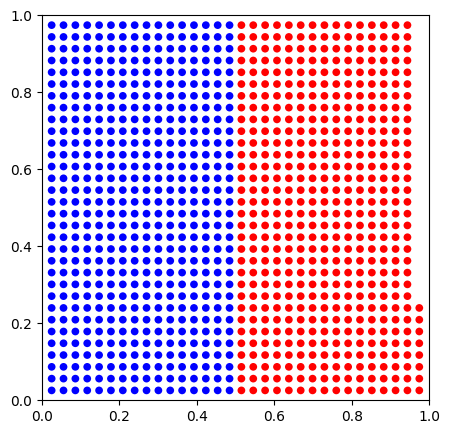

In [53]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
def animate(i):
    ax.clear()
    p = positions[i]
    redx, redy = p[0][red], p[1][red]
    bluex, bluey = p[0][blue], p[1][blue]

    red_circles = [plt.Circle((x,y), radius=RADIUS, linewidth=0) for x,y in zip(redx, redy)]
    blue_circles = [plt.Circle((x,y), radius=RADIUS, linewidth=0) for x,y in zip(bluex, bluey)]
    cred = matplotlib.collections.PatchCollection(red_circles, facecolors = 'red')
    cblue = matplotlib.collections.PatchCollection(blue_circles, facecolors = 'blue')

    ax.add_collection(cred)
    ax.add_collection(cblue)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

ani = animation.FuncAnimation(fig, animate, frames=FRAMES, interval=20)
ani.save('thousand_success.mp4', writer='ffmpeg', fps=50, dpi=200)